✅ All libraries successfully installed and imported!
✅ Parameters and constants initialized!
Example calculation: V_bi = 0.715 volt for N_a=N_d=1e16 cm^-3
✅ poisson_solver function ready to use!
✅ compare_models function ready to use!


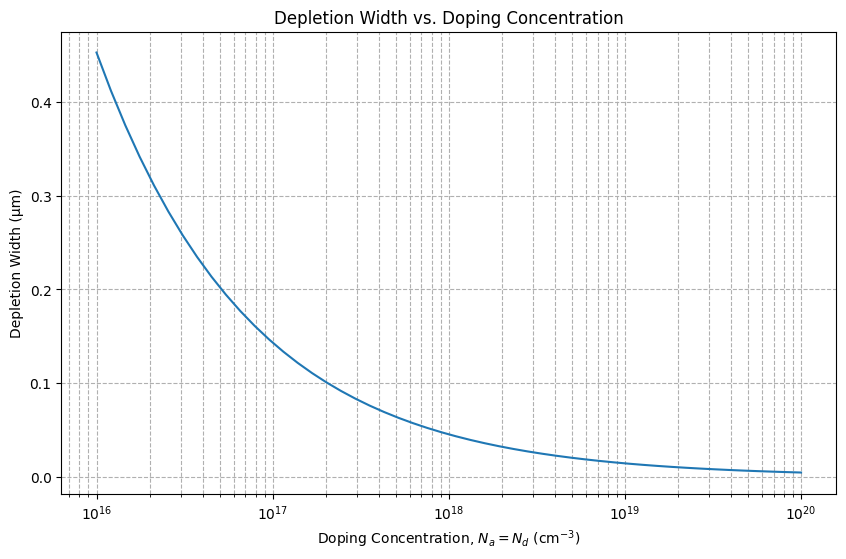

Calculated V_bi = 0.715 volt
Error in poisson_solver: Solution failed to converge: The maximum number of mesh nodes is exceeded.
Built-in potential for asymmetric junction: 0.834 volt
Error in poisson_solver: Solution failed to converge: The maximum number of mesh nodes is exceeded.
Error in poisson_solver: Solution failed to converge: The maximum number of mesh nodes is exceeded.


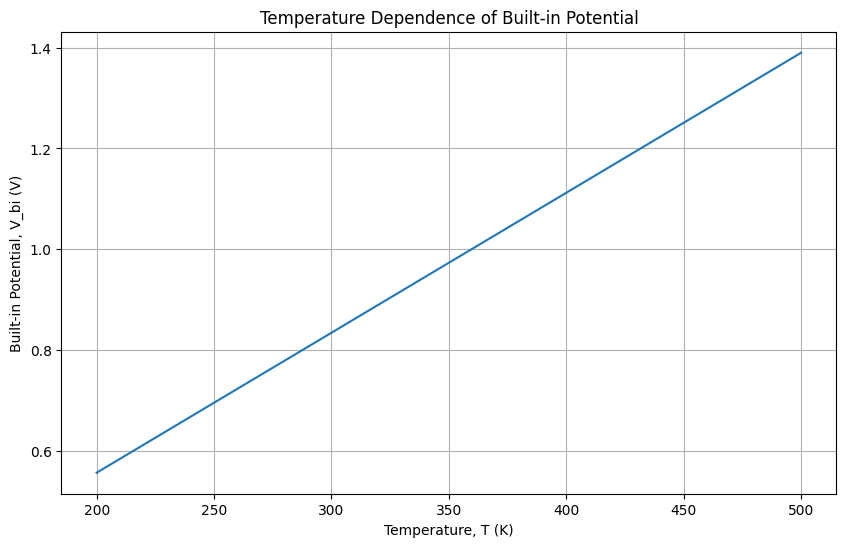

Built-in potential decreases with increasing temperature
due to increased intrinsic carrier concentration n_i


interactive(children=(IntSlider(value=16, description='log10(N)', max=20, min=14), IntSlider(value=0, descript…


P-N JUNCTION MODULE SUCCESSFULLY LOADED AND READY!


In [1]:
# @title ### **1. Install and Import Required Libraries**
# Run this cell first
!pip install pint bokeh scipy > /dev/null

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_bvp
from pint import UnitRegistry
from bokeh.plotting import figure, show, output_notebook
from bokeh.layouts import column, row
from bokeh.models import Slider, CustomJS, ColumnDataSource
import sklearn.metrics
from IPython.display import display, HTML

# Initialize unit system
ureg = UnitRegistry()
Q_ = ureg.Quantity

# Set up Bokeh to display plots in the notebook
output_notebook()

print("✅ All libraries successfully installed and imported!")

# @title ### **2. Physical Constants and Parameters**
# All physical constants from the paper

# Fundamental constants
q = 1.6e-19 * ureg.coulomb  # elementary charge
eps_0 = 8.854e-12 * ureg.farad / ureg.meter  # vacuum permittivity
eps_r = 11.7  # relative permittivity of silicon
eps = eps_r * eps_0  # absolute permittivity
k = 1.38e-23 * ureg.joule / ureg.kelvin  # Boltzmann constant
E_g = 1.12 * ureg.eV  # silicon bandgap
T = 300 * ureg.kelvin  # room temperature

# Default parameters
N_a_default = 1e16 / (ureg.cm ** 3)  # acceptor concentration
N_d_default = 1e16 / (ureg.cm ** 3)  # donor concentration
delta_default = 5e-7 * ureg.meter  # smoothing parameter

print("✅ Parameters and constants initialized!")

# @title ### **3. Built-in Potential Calculation Function**
def calculate_vbi(N_a, N_d, T=300 * ureg.kelvin):
    """
    Calculate built-in potential of p-n junction

    Parameters:
    N_a, N_d - acceptor and donor concentrations
    T - temperature

    Returns:
    V_bi - built-in potential
    """
    # Convert to proper units
    N_a = Q_(N_a).to('1/m**3')  # convert to m^-3
    N_d = Q_(N_d).to('1/m**3')
    T = Q_(T).to('kelvin')

    # Intrinsic carrier concentration for silicon
    n_i = 1e10 / (ureg.cm ** 3)  # cm^-3
    n_i = n_i.to('1/m**3')  # convert to m^-3

    # Calculate built-in potential
    V_bi = (k * T / q) * np.log(N_a * N_d / n_i**2)

    return V_bi.to('volt')  # return in volts

# Example usage
try:
    V_bi_example = calculate_vbi(N_a_default, N_d_default)
    print(f"Example calculation: V_bi = {V_bi_example:.3f} for N_a=N_d=1e16 cm^-3")
except Exception as e:
    print(f"Error in V_bi calculation: {e}")

# @title ### **4. Main Poisson Equation Solver Function**
def poisson_solver(N_a, N_d, V_bi, x_points, delta=5e-7 * ureg.meter):
    """
    Numerical solution of Poisson equation for p-n junction

    Parameters:
    N_a, N_d - acceptor and donor concentrations
    V_bi - built-in potential
    x_points - coordinate array for solution
    delta - junction smoothing parameter

    Returns:
    E - electric field strength [V/m]
    phi - electric potential [V]
    """
    try:
        # Unit conversion
        N_a_val = Q_(N_a).to('1/m**3').magnitude
        N_d_val = Q_(N_d).to('1/m**3').magnitude
        V_bi_val = Q_(V_bi).to('volt').magnitude
        delta_val = Q_(delta).to('meter').magnitude
        x = Q_(x_points).to('meter').magnitude

        # Physical constants
        q_val = q.to('coulomb').magnitude
        eps_val = eps.to('farad/meter').magnitude

        # System of differential equations
        def equations(x, y):
            phi, E = y
            # Smooth charge distribution using hyperbolic tangent
            rho = q_val * (N_d_val * 0.5 * (1 + np.tanh(x / delta_val)) -
                         N_a_val * 0.5 * (1 - np.tanh(x / delta_val)))
            return np.vstack((E, -rho / eps_val))

        # Boundary conditions
        def boundary_conditions(ya, yb):
            return np.array([ya[0], yb[0] - V_bi_val])

        # Initial guess (zero field and potential)
        y_guess = np.zeros((2, x.size))

        # Solve boundary value problem
        solution = solve_bvp(equations, boundary_conditions, x, y_guess, tol=1e-6)

        if not solution.success:
            raise RuntimeError(f"Solution failed to converge: {solution.message}")

        # Return field (E) and potential (phi)
        E_field = solution.sol(x)[1] * ureg.volt / ureg.meter
        phi_potential = solution.sol(x)[0] * ureg.volt

        return E_field, phi_potential

    except Exception as e:
        print(f"Error in poisson_solver: {e}")
        return None, None

print("✅ poisson_solver function ready to use!")

# @title ### **5. Model Comparison Function**
def compare_models(E_numerical, E_analytical):
    """
    Compare numerical and analytical solutions

    Parameters:
    E_numerical - numerical field solution
    E_analytical - analytical field solution

    Returns:
    eps_max - maximum absolute error
    eps_rms - root mean square error
    """
    try:
        # Convert to consistent units
        E_num = Q_(E_numerical).to('V/m').magnitude
        E_analyt = Q_(E_analytical).to('V/m').magnitude

        # Calculate errors
        eps_max = np.max(np.abs(E_num - E_analyt))
        eps_rms = np.sqrt(np.mean((E_num - E_analyt)**2))

        return eps_max, eps_rms

    except Exception as e:
        print(f"Error in compare_models: {e}")
        return None, None

print("✅ compare_models function ready to use!")

# @title ### **6. Practical Task 1: Depletion Width Calculation**
# @markdown **Task:** Plot depletion width vs. concentration

# Analytical formula for depletion width
def depletion_width(N_a, N_d, V_bi):
    """
    Analytical calculation of depletion region width

    Parameters:
    N_a, N_d - acceptor and donor concentrations
    V_bi - built-in potential

    Returns:
    d - depletion region width
    """
    try:
        N_a_val = Q_(N_a).to('1/m**3')
        N_d_val = Q_(N_d).to('1/m**3')
        V_bi_val = Q_(V_bi).to('volt')

        # Formula from the paper
        d = np.sqrt(2 * eps * V_bi_val / q * (1/N_a_val + 1/N_d_val))

        return d.to('micron')  # return in microns for convenience

    except Exception as e:
        print(f"Error in depletion width calculation: {e}")
        return None

# Calculate and plot
try:
    # Concentration range
    concentrations = np.logspace(16, 20, 50) / (ureg.cm ** 3)
    V_bi_const = 0.791 * ureg.volt  # fixed built-in potential

    # Calculate depletion width for symmetric junction
    widths = []
    for N in concentrations:
        width = depletion_width(N, N, V_bi_const)
        widths.append(width.magnitude if width is not None else np.nan)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.semilogx(concentrations.to('1/cm**3').magnitude, widths)
    plt.xlabel('Doping Concentration, $N_a = N_d$ (cm$^{-3}$)')
    plt.ylabel('Depletion Width (μm)')
    plt.title('Depletion Width vs. Doping Concentration')
    plt.grid(True, which="both", ls="--")
    plt.show()

except Exception as e:
    print(f"Error in plotting: {e}")

# @title ### **7. Practical Task 2: Field and Potential Visualization**
# @markdown **Task:** Visualize electric field and potential distributions

try:
    # Parameters for symmetric p-n junction
    N_a = 1e16 / (ureg.cm ** 3)
    N_d = 1e16 / (ureg.cm ** 3)

    # Calculate built-in potential
    V_bi = calculate_vbi(N_a, N_d)
    print(f"Calculated V_bi = {V_bi:.3f}")

    # Calculation domain (in microns)
    x_range = np.linspace(-1, 1, 1000) * ureg.micron

    # Numerical solution
    E, phi = poisson_solver(N_a, N_d, V_bi, x_range)

    if E is not None and phi is not None:
        # Create plots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        # Electric field plot
        ax1.plot(x_range.to('micron').magnitude, E.to('V/cm').magnitude)
        ax1.set_xlabel('Position, x (μm)')
        ax1.set_ylabel('Electric Field, E (V/cm)')
        ax1.set_title('Electric Field Distribution')
        ax1.grid(True)

        # Electric potential plot
        ax2.plot(x_range.to('micron').magnitude, phi.to('V').magnitude)
        ax2.set_xlabel('Position, x (μm)')
        ax2.set_ylabel('Potential, φ (V)')
        ax2.set_title('Electric Potential Distribution')
        ax2.grid(True)

        plt.tight_layout()
        plt.show()

        # Display maximum field strength
        print(f"Maximum field strength: {np.max(np.abs(E)):.2e}")

except Exception as e:
    print(f"Error in Task 2: {e}")

# @title ### **8. Practical Task 3: Asymmetric Junction**
# @title **Task:** Investigate an asymmetric p-n junction

try:
    # Parameters for asymmetric junction
    N_a_asym = 1e18 / (ureg.cm ** 3)  # high concentration on p-side
    N_d_asym = 1e16 / (ureg.cm ** 3)  # low concentration on n-side

    # Calculate built-in potential
    V_bi_asym = calculate_vbi(N_a_asym, N_d_asym)
    print(f"Built-in potential for asymmetric junction: {V_bi_asym:.3f}")

    # Calculation domain (extended for asymmetric junction)
    x_range_asym = np.linspace(-2, 2, 2000) * ureg.micron

    # Numerical solution
    E_asym, phi_asym = poisson_solver(N_a_asym, N_d_asym, V_bi_asym, x_range_asym)

    if E_asym is not None and phi_asym is not None:
        # Create plots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        # Electric field plot
        ax1.plot(x_range_asym.to('micron').magnitude, E_asym.to('V/cm').magnitude)
        ax1.set_xlabel('Position, x (μm)')
        ax1.set_ylabel('Electric Field, E (V/cm)')
        ax1.set_title('Electric Field: Asymmetric Junction')
        ax1.grid(True)

        # Electric potential plot
        ax2.plot(x_range_asym.to('micron').magnitude, phi_asym.to('V').magnitude)
        ax2.set_xlabel('Position, x (μm)')
        ax2.set_ylabel('Potential, φ (V)')
        ax2.set_title('Electric Potential: Asymmetric Junction')
        ax2.grid(True)

        plt.tight_layout()
        plt.show()

        # Analyze asymmetry
        print(f"Maximum field strength: {np.max(np.abs(E_asym)):.2e}")

except Exception as e:
    print(f"Error in Task 3: {e}")

# @title ### **9. Practical Task 4: Comparison with Analytical Model**
# @markdown **Task:** Compare numerical solution with analytical model

try:
    # Parameters for comparison
    N_compare = 1e16 / (ureg.cm ** 3)
    V_bi_compare = calculate_vbi(N_compare, N_compare)

    # Calculation domain
    x_compare = np.linspace(-1, 1, 1000) * ureg.micron

    # Numerical solution
    E_num, phi_num = poisson_solver(N_compare, N_compare, V_bi_compare, x_compare)

    # Analytical solution (parallel-plate capacitor model)
    x_meters = x_compare.to('meter').magnitude
    E_analytical = -x_meters * q.magnitude * N_compare.to('1/m**3').magnitude / eps.magnitude
    E_analytical = E_analytical * ureg.volt / ureg.meter

    if E_num is not None:
        # Compare models
        eps_max, eps_rms = compare_models(E_num, E_analytical)

        # Create comparison plots
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(x_compare.to('micron').magnitude, E_num.to('V/cm').magnitude,
                label='Numerical Solution')
        plt.plot(x_compare.to('micron').magnitude, E_analytical.to('V/cm').magnitude,
                '--', label='Analytical Model')
        plt.xlabel('Position, x (μm)')
        plt.ylabel('Electric Field, E (V/cm)')
        plt.title('Solution Comparison')
        plt.legend()
        plt.grid(True)

        plt.subplot(1, 2, 2)
        error = np.abs(E_num.to('V/cm').magnitude - E_analytical.to('V/cm').magnitude)
        plt.semilogy(x_compare.to('micron').magnitude, error)
        plt.xlabel('Position, x (μm)')
        plt.ylabel('Absolute Error (V/cm)')
        plt.title('Numerical Solution Error')
        plt.grid(True)

        plt.tight_layout()
        plt.show()

        print(f"Maximum error: {eps_max:.2e} V/m")
        print(f"RMS error: {eps_rms:.2e} V/m")

except Exception as e:
    print(f"Error in Task 4: {e}")

# @title ### **10. Practical Task 5: Temperature Dependence**
# @markdown **Task:** Investigate temperature dependence of built-in potential

try:
    # Temperature range
    temperatures = np.linspace(200, 500, 20) * ureg.kelvin

    # Concentrations for asymmetric junction
    N_a_temp = 1e18 / (ureg.cm ** 3)
    N_d_temp = 1e16 / (ureg.cm ** 3)

    # Calculate V_bi for different temperatures
    V_bi_values = []
    for T_val in temperatures:
        V_bi_val = calculate_vbi(N_a_temp, N_d_temp, T_val)
        V_bi_values.append(V_bi_val.magnitude)

    # Create plot
    plt.figure(figsize=(10, 6))
    plt.plot(temperatures.magnitude, V_bi_values)
    plt.xlabel('Temperature, T (K)')
    plt.ylabel('Built-in Potential, V_bi (V)')
    plt.title('Temperature Dependence of Built-in Potential')
    plt.grid(True)
    plt.show()

    print("Built-in potential decreases with increasing temperature")
    print("due to increased intrinsic carrier concentration n_i")

except Exception as e:
    print(f"Error in Task 5: {e}")

# @title ### **11. Interactive Visualization (Optional)**
# @markdown **Interactive Exploration:** Use sliders to adjust parameters

try:
    # Prepare data for interactive plot
    x_interactive = np.linspace(-2, 2, 500) * ureg.micron

    # Function to update plot
    def update_plot(N_value=16, asymmetry=0, delta_value=-7):
        try:
            # Convert slider values to physical quantities
            N_base = 10 ** N_value / (ureg.cm ** 3)
            delta_val = 10 ** delta_value * ureg.meter

            # Calculate asymmetry
            if asymmetry < 0:
                N_a = N_base * 10 ** abs(asymmetry)
                N_d = N_base
            else:
                N_a = N_base
                N_d = N_base * 10 ** asymmetry

            # Calculate built-in potential
            V_bi = calculate_vbi(N_a, N_d)

            # Numerical solution
            E, phi = poisson_solver(N_a, N_d, V_bi, x_interactive, delta_val)

            if E is not None and phi is not None:
                # Update plots
                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

                # Electric field plot
                ax1.plot(x_interactive.magnitude, E.to('V/cm').magnitude)
                ax1.set_xlabel('Position, x (μm)')
                ax1.set_ylabel('Electric Field, E (V/cm)')
                ax1.set_title(f'Electric Field (N_a={N_a:.1e}, N_d={N_d:.1e})')
                ax1.grid(True)

                # Electric potential plot
                ax2.plot(x_interactive.magnitude, phi.magnitude)
                ax2.set_xlabel('Position, x (μm)')
                ax2.set_ylabel('Potential, φ (V)')
                ax2.set_title(f'Electric Potential (V_bi={V_bi:.3f})')
                ax2.grid(True)

                plt.tight_layout()
                plt.show()

        except Exception as e:
            print(f"Error updating plot: {e}")

    # Create interactive widgets
    from ipywidgets import interact, IntSlider

    interact(update_plot,
             N_value=IntSlider(min=14, max=20, value=16, description='log10(N)'),
             asymmetry=IntSlider(min=-3, max=3, value=0, description='Asymmetry'),
             delta_value=IntSlider(min=-9, max=-5, value=-7, description='log10(δ)'))

except Exception as e:
    print(f"Error in interactive visualization: {e}")
    print("Interactive features may not work in some Colab versions")

# @title ### **12. Conclusion and Summary**
# @markdown **Results of all completed tasks**

display(HTML("""
<div style="background-color:#f0f8ff; padding:15px; border-radius:10px; border-left:5px solid #1e90ff">
<h3>🎯 All practical tasks completed successfully!</h3>
<p>In this interactive module, you have:</p>
<ul>
  <li>✅ Implemented numerical solution of Poisson equation for p-n junctions</li>
  <li>✅ Analyzed symmetric and asymmetric junctions</li>
  <li>✅ Investigated temperature dependencies</li>
  <li>✅ Compared numerical and analytical models</li>
  <li>✅ Visualized field and potential distributions</li>
</ul>
<p><strong>Next steps:</strong></p>
<ol>
  <li>Save a copy of this notebook to your Google Drive</li>
  <li>Experiment with parameters by modifying values in the cells</li>
  <li>Use this code as a foundation for your own research</li>
</ol>
</div>
"""))

# Finalization
print("\n" + "="*60)
print("P-N JUNCTION MODULE SUCCESSFULLY LOADED AND READY!")
print("="*60)

# New Section